# Use of Fatal Force by the US Police

In the United States, use of deadly force by police has been a high-profile and contentious issue. 1000 people are shot and killed by US cops each year. The ever-growing argument is that the US has a flawed Law Enforcement system that costs too many innocent civilians their lives. In this project, we will analyze one of America’s hottest political topics, which encompasses issues ranging from institutional racism to the role of Law Enforcement personnel in society.

We will use 5 data sets in this study. Four of them describes demographics of cities in the US (city data sets) while the remaining one records the fatal incidents (police data set).

In [15]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import pickle

from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential

## Data Preprocessing

In [168]:
education = pd.read_csv('data/education.csv', encoding = "ISO-8859-1")
income = pd.read_csv('data/income.csv', encoding = "ISO-8859-1")
poverty = pd.read_csv('data/poverty.csv', encoding = "ISO-8859-1")
race = pd.read_csv('data/share_race_by_city.csv', encoding = "ISO-8859-1")
test = pd.read_csv('data/police_killings_test.csv', encoding = "ISO-8859-1")
train = pd.read_csv('data/police_killings_train.csv', encoding = "ISO-8859-1")

We first inspect and clean null data.

In [169]:
train.isnull().sum()

id                          0
name                        0
date                        0
manner_of_death             0
armed                       6
age                        37
gender                      0
race                       91
city                        0
state                       0
signs_of_mental_illness     0
threat_level                0
flee                       27
body_camera                 0
dtype: int64

In [170]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [171]:
train = clean_dataset(train)
test = clean_dataset(test)

### Merging Counts to City Data Sets

By merging the count of fatal incident grouped by city to the city data sets, we can perform linear regression using demographics as independent variables and count as a depedent variable.

There is a discrepancy between the encoding of names between the police data set and city data sets. For example, the former refer LA in California as Los Angeles while the latter uses Los Angeles city.

We also observe that the police data set provide less information because it only has Chicago as a city, while the city data sets have Chicago city, Chicago Heights city and Chicago Ridge village. Assuming that cities bearing similar name should be geographically and demographically close to each other, we shall evenly distribute the number of fatal incidents between them.

In [172]:
# count the number of incidents grouping by city and state because city names may duplicate
df = pd.concat([train, test], ignore_index=True)
city_count = df.value_counts(['city', 'state']).rename_axis(['City', 'Geographic Area']).reset_index(name='Counts')
city_count.head()

,City,Geographic Area,Counts
0,Los Angeles,CA,35
1,Phoenix,AZ,28
2,Houston,TX,23
3,Chicago,IL,22
4,Las Vegas,NV,17


In [173]:
city = education.merge(income, on=['Geographic Area', 'City']).merge(poverty, on=['Geographic Area', 'City']).merge(race, on=['Geographic Area', 'City'])
city.head()

,Geographic Area,City,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AL,Abanda CDP,21.2,11207,78.8,67.2,30.2,0,0,1.6
1,AL,Abbeville city,69.1,25615,29.1,54.4,41.4,0.1,1,3.1
2,AL,Adamsville city,78.9,42575,25.5,52.3,44.9,0.5,0.3,2.3
3,AL,Addison town,81.4,37083,30.7,99.1,0.1,0,0.1,0.4
4,AL,Akron town,68.6,21667,42,13.2,86.5,0,0,0.3


In [174]:
def merge_count(record):
    # find record(s) matching both name and state
    match_city = city_total['City'].str.startswith(record['City'])
    match_state = city_total['Geographic Area'] == record['Geographic Area']
    match_both = np.logical_and(match_city, match_state)
    # count the number of True
    length = np.count_nonzero(match_both)
    if length == 1:     # if unique
        city_total.loc[match_both, 'Counts'] = record['Counts']
    elif length > 1:    # if multiple, take average
        count = record['Counts']/length
        city_total.loc[match_both, 'Counts'] = count

city_total = city.copy()    # changes to city_total will not affect city
city_total['Counts'] = 0
city_count.apply(merge_count, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1377    None
1378    None
1379    None
1380    None
1381    None
Length: 1382, dtype: object

In [175]:
city_total.sort_values(by='Counts', ascending=False).head()

,Geographic Area,City,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,Counts
2701,CA,Los Angeles city,75.5,50205,22.1,49.8,9.6,0.7,11.3,48.5,35.0
1198,AZ,Phoenix city,80.7,47326,23.1,65.9,6.5,2.2,3.2,40.8,28.0
25036,TX,Houston city,76.7,46187,22.5,50.5,23.7,0.7,6,43.8,23.0
15596,NV,Las Vegas city,83.3,50202,17.5,62.1,11.1,0.7,6.1,31.5,17.0
24428,TX,Austin city,87.5,57689,18,68.3,8.1,0.9,6.3,35.1,16.0


### Merging City Data Sets to the Police Data Set

By merging the city demographics to the police data set, we can append background information to each of the incident. In this study, we will use various city demographics as independent variables to predict the race of victim.

In [176]:
fields = ['percent_completed_hs', 'Median Income', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']

def merge_city(record):
    # find record(s) matching both name and state
    match_city = city['City'].str.startswith(record['city'])
    match_state = city['Geographic Area'] == record['state']
    match_both = np.logical_and(match_city, match_state)
    match = city.loc[match_both]
    # assign the mean of city demographics to the police data set
    for field in fields:
        record.loc[field] = pd.to_numeric(match[field], errors='coerce').mean()
    return record[fields]

train[fields] = train.apply(merge_city, axis=1)
test[fields] = test.apply(merge_city, axis=1)

In [177]:
train.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,flee,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,...,Not fleeing,False,80.1,37072.0,28.6,78.9,0.8,3.7,1.1,19.2
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,...,Not fleeing,False,88.1,65765.0,14.9,70.9,2.6,1.0,8.9,21.1
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,Not fleeing,False,87.5,45947.0,17.3,71.9,11.5,1.2,4.8,15.3
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,...,Not fleeing,False,87.0,81294.0,13.2,48.5,6.1,0.5,33.3,15.1
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,...,Not fleeing,False,76.3,47791.0,16.6,76.5,0.9,1.2,0.9,43.1


Since some rows in the police data set do not have corresponding cities, they will have NaN values which needs to be cleaned.

In [178]:
train = clean_dataset(train)
test = clean_dataset(test)

In [179]:
train.to_csv('processed/train.csv', index=False)
test.to_csv('processed/test.csv', index=False)

### Recoding Features

There are too many unique values for the column armed. Since we only study whether the victim is armed or not, we can convert all values other than 'unarmed' and 'undetermined' to 'armed'.

In [180]:
train['armed'].value_counts()

gun                                 931
knife                               250
unarmed                             134
vehicle                             107
toy weapon                           80
undetermined                         76
machete                              14
sword                                 8
unknown weapon                        6
box cutter                            5
ax                                    5
metal pipe                            5
Taser                                 5
hammer                                5
baseball bat                          4
screwdriver                           4
gun and knife                         4
hatchet                               4
scissors                              3
guns and explosives                   3
blunt object                          3
rock                                  2
meat cleaver                          2
shovel                                2
metal stick                           2


In [181]:
#train['armed'].where(np.logical_or(train['armed'] == 'unarmed', train['armed'] == 'undetermined'), 'armed', inplace=True)
#test['armed'].where(np.logical_or(test['armed'] == 'unarmed', test['armed'] == 'undetermined'), 'armed', inplace=True)
#train['armed'].value_counts()
# Dont think this is necessary

To make the features interpretable to the classifier, we create dummy columns for categorical varialbes. We then proceed to separate the independent and the dependent variables in the data set, while also eliminate columns that are irrelevant to the study. We also eliminate city and state information because they are already represented by the parameters in the city data sets.

In [182]:
X_train = pd.get_dummies(train.drop(columns=['id', 'name', 'race', 'date', 'city', 'state']))
y_train = train['race']
X_test = pd.get_dummies(test.drop(columns=['id', 'name', 'race', 'date', 'city', 'state']))
y_test = test['race']

In [183]:
X_train.head()

,age,signs_of_mental_illness,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,...,armed_vehicle,gender_F,gender_M,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,53.0,True,False,80.1,37072.0,28.6,78.9,0.8,3.7,1.1,...,0,0,1,1,0,0,0,0,1,0
1,47.0,False,False,88.1,65765.0,14.9,70.9,2.6,1.0,8.9,...,0,0,1,1,0,0,0,0,1,0
2,23.0,False,False,87.5,45947.0,17.3,71.9,11.5,1.2,4.8,...,0,0,1,0,1,0,0,0,1,0
3,32.0,True,False,87.0,81294.0,13.2,48.5,6.1,0.5,33.3,...,0,0,1,1,0,0,0,0,1,0
4,39.0,False,False,76.3,47791.0,16.6,76.5,0.9,1.2,0.9,...,0,0,1,1,0,0,0,0,1,0


In [184]:
y_train.head()

0    A
1    W
2    H
3    W
4    H
Name: race, dtype: object

## Exploratory Data Analysis

In [185]:
X_test.head()

,age,signs_of_mental_illness,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,...,armed_vehicle,gender_F,gender_M,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,54.0,False,False,88.4,58227.0,11.4,71.0,22.2,0.3,1.7,...,0,0,1,1,0,0,0,0,1,0
1,50.0,True,True,82.0,50536.0,14.7,96.0,0.0,3.2,0.0,...,0,0,1,1,0,0,0,0,1,0
2,28.0,False,False,88.4,53637.0,16.8,50.0,35.0,0.5,5.0,...,0,0,1,0,1,0,1,0,0,0
3,59.0,True,True,90.9,61442.0,7.3,74.7,19.0,0.2,3.2,...,0,0,1,1,0,0,0,0,1,0
4,24.0,False,True,89.0,47527.0,24.6,38.4,54.0,0.2,3.1,...,0,0,1,0,1,0,1,0,0,0


In [186]:
X_train.tail()

,age,signs_of_mental_illness,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,...,armed_vehicle,gender_F,gender_M,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
2021,26.0,False,True,85.2,36792.0,27.0,33.0,60.2,0.3,2.9,...,0,0,1,1,0,0,1,0,0,0
2022,27.0,False,False,79.6,57095.0,19.8,56.8,8.2,1.5,6.2,...,0,0,1,1,0,0,0,0,0,1
2023,29.0,True,True,85.5,41330.0,24.4,75.3,2.4,1.7,1.6,...,0,0,1,1,0,0,0,1,0,0
2026,32.0,False,False,92.9,57417.0,13.2,91.2,0.6,0.8,0.7,...,0,0,1,1,0,0,1,0,0,0
2027,37.0,True,False,83.5,51375.0,11.7,80.5,12.6,0.4,1.1,...,1,0,1,1,0,0,1,0,0,0


In [187]:
y_train.head()

0    A
1    W
2    H
3    W
4    H
Name: race, dtype: object

In [188]:
y_train.tail()

2021    B
2022    H
2023    H
2026    H
2027    W
Name: race, dtype: object

In [189]:
train.interpolate()
train.isnull().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
percent_completed_hs       0
Median Income              0
poverty_rate               0
share_white                0
share_black                0
share_native_american      0
share_asian                0
share_hispanic             0
dtype: int64

In [190]:
train.shape

(1697, 22)

In [191]:
train.info

<bound method DataFrame.info of         id                         name      date   manner_of_death  \
0        3                   Tim Elliot  02/01/15              shot   
1        4             Lewis Lee Lembke  02/01/15              shot   
2        5           John Paul Quintero  03/01/15  shot and Tasered   
3        8              Matthew Hoffman  04/01/15              shot   
4        9            Michael Rodriguez  04/01/15              shot   
...    ...                          ...       ...               ...   
2021  2254               Arties Manning  24/01/17              shot   
2022  2255  Antonio Arturo Perez Garcia  24/01/17              shot   
2023  2256         Jeremy Lopez-Robledo  24/01/17              shot   
2026  2259                Ramon Milanez  24/01/17              shot   
2027  2260             Micah R. Lambert  25/01/17              shot   

           armed   age gender race           city state  ...         flee  \
0            gun  53.0      M    A    

In [192]:
train.describe()

,id,age,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
count,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000
mean,1149.212139,35.873306,84.316807,49455.544603,19.367568,67.292879,15.205275,1.432133,4.359952,20.627339
std,632.922020,12.483521,8.365033,16450.198560,8.087651,19.467030,17.309810,4.954118,6.374263,20.176668
min,3.000000,6.000000,33.150000,17438.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000
25%,617.000000,26.000000,80.700000,39681.000000,14.300000,52.700000,2.500000,0.300000,1.000000,5.133333
50%,1151.000000,34.000000,85.600000,46912.000000,19.000000,69.700000,8.400000,0.600000,2.400000,12.700000
75%,1688.000000,44.000000,89.800000,54618.000000,23.400000,82.500000,22.600000,1.000000,5.000000,32.700000
max,2260.000000,83.000000,100.000000,198839.000000,76.400000,100.000000,98.000000,95.000000,61.900000,97.800000


In [193]:
train.nunique()

id                         1697
name                       1693
date                        672
manner_of_death               2
armed                        56
age                          69
gender                        2
race                          6
city                        941
state                        51
signs_of_mental_illness       2
threat_level                  3
flee                          4
body_camera                   2
percent_completed_hs        362
Median Income               995
poverty_rate                381
share_white                 543
share_black                 409
share_native_american       114
share_asian                 199
share_hispanic              433
dtype: int64

Lets explore how the fatal police shootings vary based on the different geographic loactions. The train dataset has 51 unique values for state. These include Washington DC in addition to the 50 states within the United States.

In [194]:
train['state'].value_counts()

CA    284
TX    159
FL    104
AZ     85
CO     53
GA     49
NC     48
OH     47
IL     46
OK     45
MO     40
WA     38
LA     38
NM     38
AL     35
TN     34
SC     34
IN     33
NV     29
MD     29
VA     29
MN     28
NY     28
PA     27
KY     27
WI     27
OR     22
MI     20
MA     19
NJ     19
KS     19
UT     16
AR     16
MS     15
WV     14
NE     14
ID     11
IA     10
DC      9
AK      8
MT      8
WY      7
SD      7
HI      6
DE      5
CT      4
ME      4
NH      3
VT      3
ND      2
RI      2
Name: state, dtype: int64

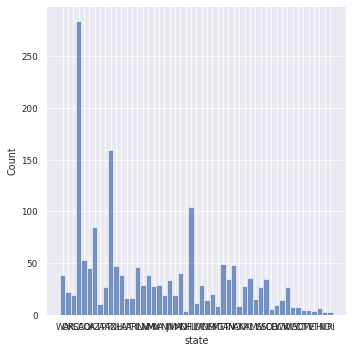

In [195]:
sns.displot(train['state'])

We can see that CA has the highest the count of all state values present in the train dataset. 

Next, we look at the cities in the dataset, to determine which city may be considered the most dangerous. There are 941 cities. Los Angeles has the highest count of all cities in our dataset, 31. The top 5 and the bottom five cities with the respect to the counts are shown. It makes sense for cities like Los Angeles, Pheonix, Huston, Chicago, and Las Vegas to have higher counts of incident reports in the dataset.

In [196]:
train['city'].value_counts()

Los Angeles    31
Phoenix        22
Houston        21
Chicago        19
Las Vegas      15
               ..
Chalmette       1
Lead            1
Dickson         1
Slidell         1
Kuna            1
Name: city, Length: 941, dtype: int64

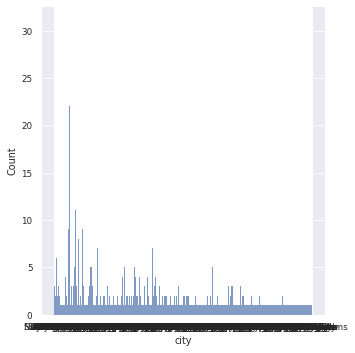

In [197]:
sns.displot(train['city'])

In the test data, a gun is the most common way of being armed. The counts of other weapons used is given below.

In [198]:
test['armed'].value_counts()

gun                        187
knife                       42
vehicle                     36
unarmed                     16
toy weapon                  14
undetermined                11
unknown weapon               4
ax                           2
hatchet and gun              1
machete                      1
pen                          1
crossbow                     1
rock                         1
Taser                        1
pipe                         1
baseball bat and bottle      1
sharp object                 1
metal object                 1
baseball bat                 1
metal stick                  1
beer bottle                  1
gun and knife                1
screwdriver                  1
Name: armed, dtype: int64

With the available data, we can also explore the age and race statistics in the dataset

([<matplotlib.patches.Wedge at 0x7f4ffdb417d0>,
 [Text(-0.2462446522228425, 1.072083751976333, 'gun'),
  Text(-0.721797878312933, -0.8300649509905527, 'knife'),
  Text(0.03698116993989552, -1.0993781847343873, 'vehicle'),
  Text(0.5591266620579769, -0.9473000452738853, 'unarmed'),
  Text(0.8053294176229895, -0.749296022350991, 'toy weapon'),
  Text(0.960454778697717, -0.5362150856482124, 'undetermined'),
  Text(1.0275054835903152, -0.3927244341670538, 'unknown weapon'),
  Text(1.0484244830356637, -0.3328755073167769, 'ax'),
  Text(1.0575818411012523, -0.30252379968010096, 'hatchet and gun'),
  Text(1.0631991429345733, -0.28214815693743095, 'machete'),
  Text(1.0684239214002174, -0.2616683476842057, 'pen'),
  Text(1.0732542475579179, -0.24109193287807812, 'crossbow'),
  Text(1.0776883380955797, -0.2204265091425878, 'rock'),
  Text(1.0817245559876643, -0.19967970596255138, 'Taser'),
  Text(1.0853614110995615, -0.17885918286732974, 'pipe'),
  Text(1.0885975607377358, -0.1579726266030028, 

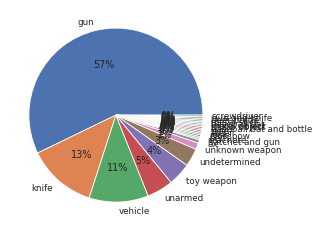

In [200]:
plt.pie(test['armed'].value_counts(), labels = test['armed'].value_counts().keys(), autopct='%.0f%%')

With the available data, we can also explore the age and race statistics in the dataset

We plot the columns to study the distribution of features.

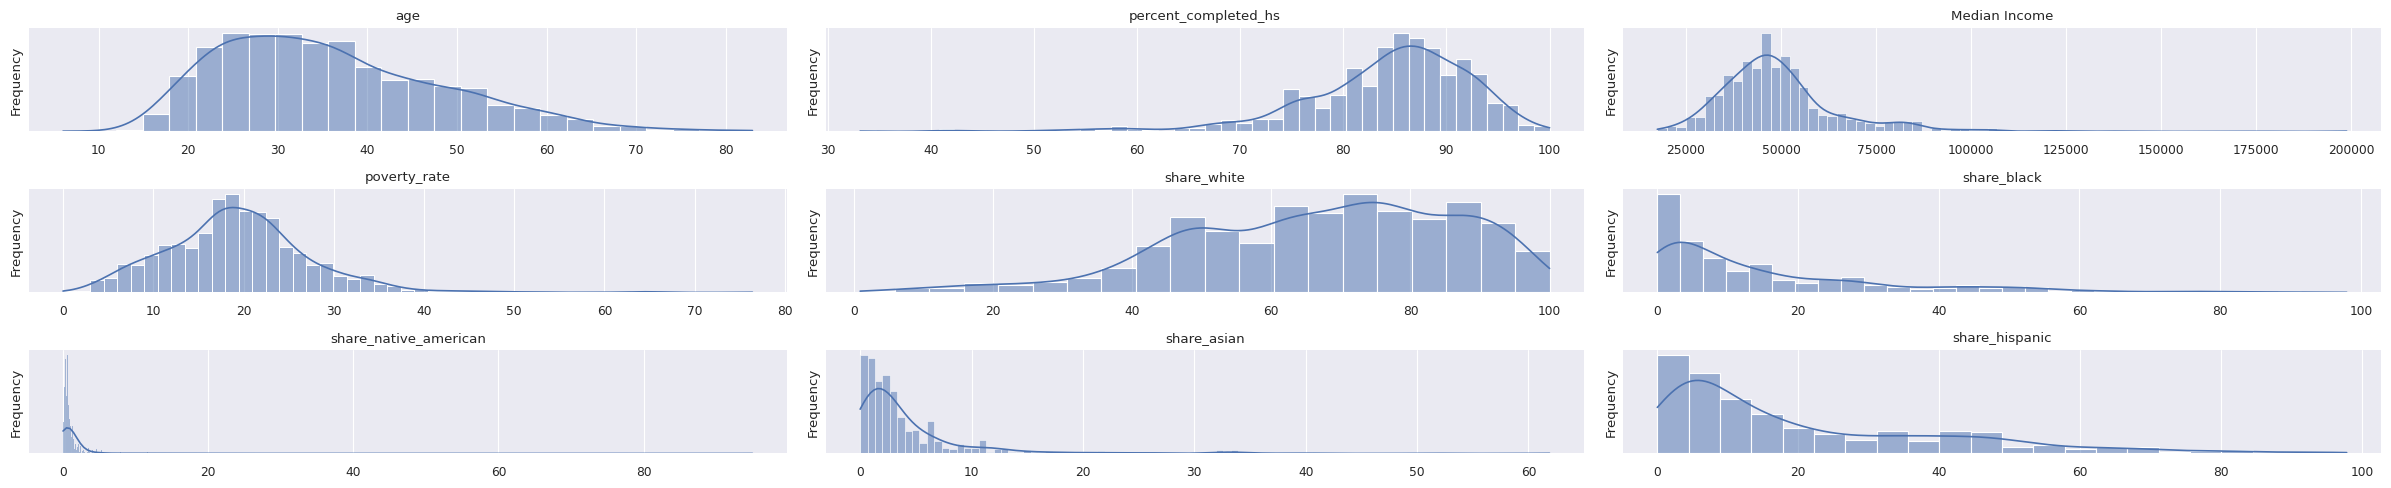

In [201]:
columns = ['age', 'percent_completed_hs', 'Median Income', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']
fig = plt.figure(dpi=100, figsize=(24, 16), tight_layout=True)
sns.set_theme()
sns.set_context("paper")
for i, col in enumerate(columns):
  ax = fig.add_subplot(10, 3, i + 1)
  sns.histplot(X_train[col], kde=True)
  ax.set_title(col)
  ax.set_yticks([])
  ax.set_ylabel("Frequency")
  ax.set_xlabel(None)
  ax.tick_params(left=False, bottom=False)
  for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [204]:
train['race'].value_counts()

W    852
B    460
H    311
A     27
O     25
N     22
Name: race, dtype: int64

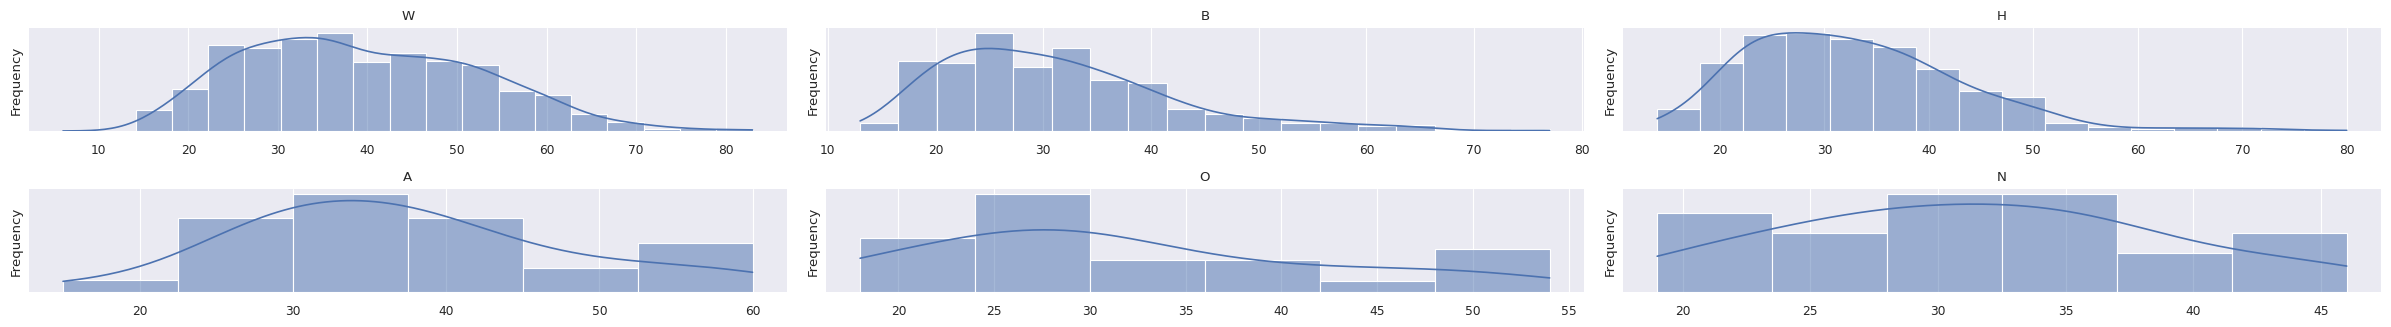

In [208]:
columns = train['race'].value_counts().keys()
fig = plt.figure(dpi=100, figsize=(24, 16), tight_layout=True)
sns.set_theme()
sns.set_context("paper")
for i, col in enumerate(columns):
  ax = fig.add_subplot(10, 3, i + 1)
  sns.histplot(train.query('race == "'+col+'"')['age'], kde=True)
  ax.set_title(col)
  ax.set_yticks([])
  ax.set_ylabel("Frequency")
  ax.set_xlabel(None)
  ax.tick_params(left=False, bottom=False)
  for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [214]:
test['race'].value_counts()

W    158
B     96
H     64
A      6
N      3
Name: race, dtype: int64

([<matplotlib.patches.Wedge at 0x7f4ffb5c0bd0>,
 [Text(0.05809720492548151, 1.0984647080265468, 'W'),
  Text(-0.7531558827299363, -0.8017207845062336, 'B'),
  Text(0.7759470135402259, -0.7796834179190967, 'H'),
  Text(1.0926978896476223, -0.12653585246732674, 'A'),
  Text(1.0995431436243845, -0.03169976827369762, 'N')],
 [Text(0.03168938450480809, 0.59916256801448, '48%'),
  Text(-0.4108122996708743, -0.4373022460943092, '29%'),
  Text(0.42324382556739587, -0.4252818643195072, '20%'),
  Text(0.5960170307168847, -0.06901955589126911, '2%'),
  Text(0.5997508056133006, -0.017290782694744156, '1%')])

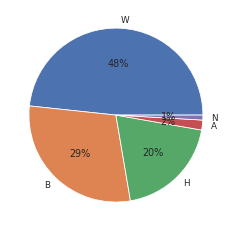

In [212]:
plt.pie(test['race'].value_counts(), labels = test['race'].value_counts().keys(), autopct='%.0f%%')

We visualise the correlation of columns with a heatmap.

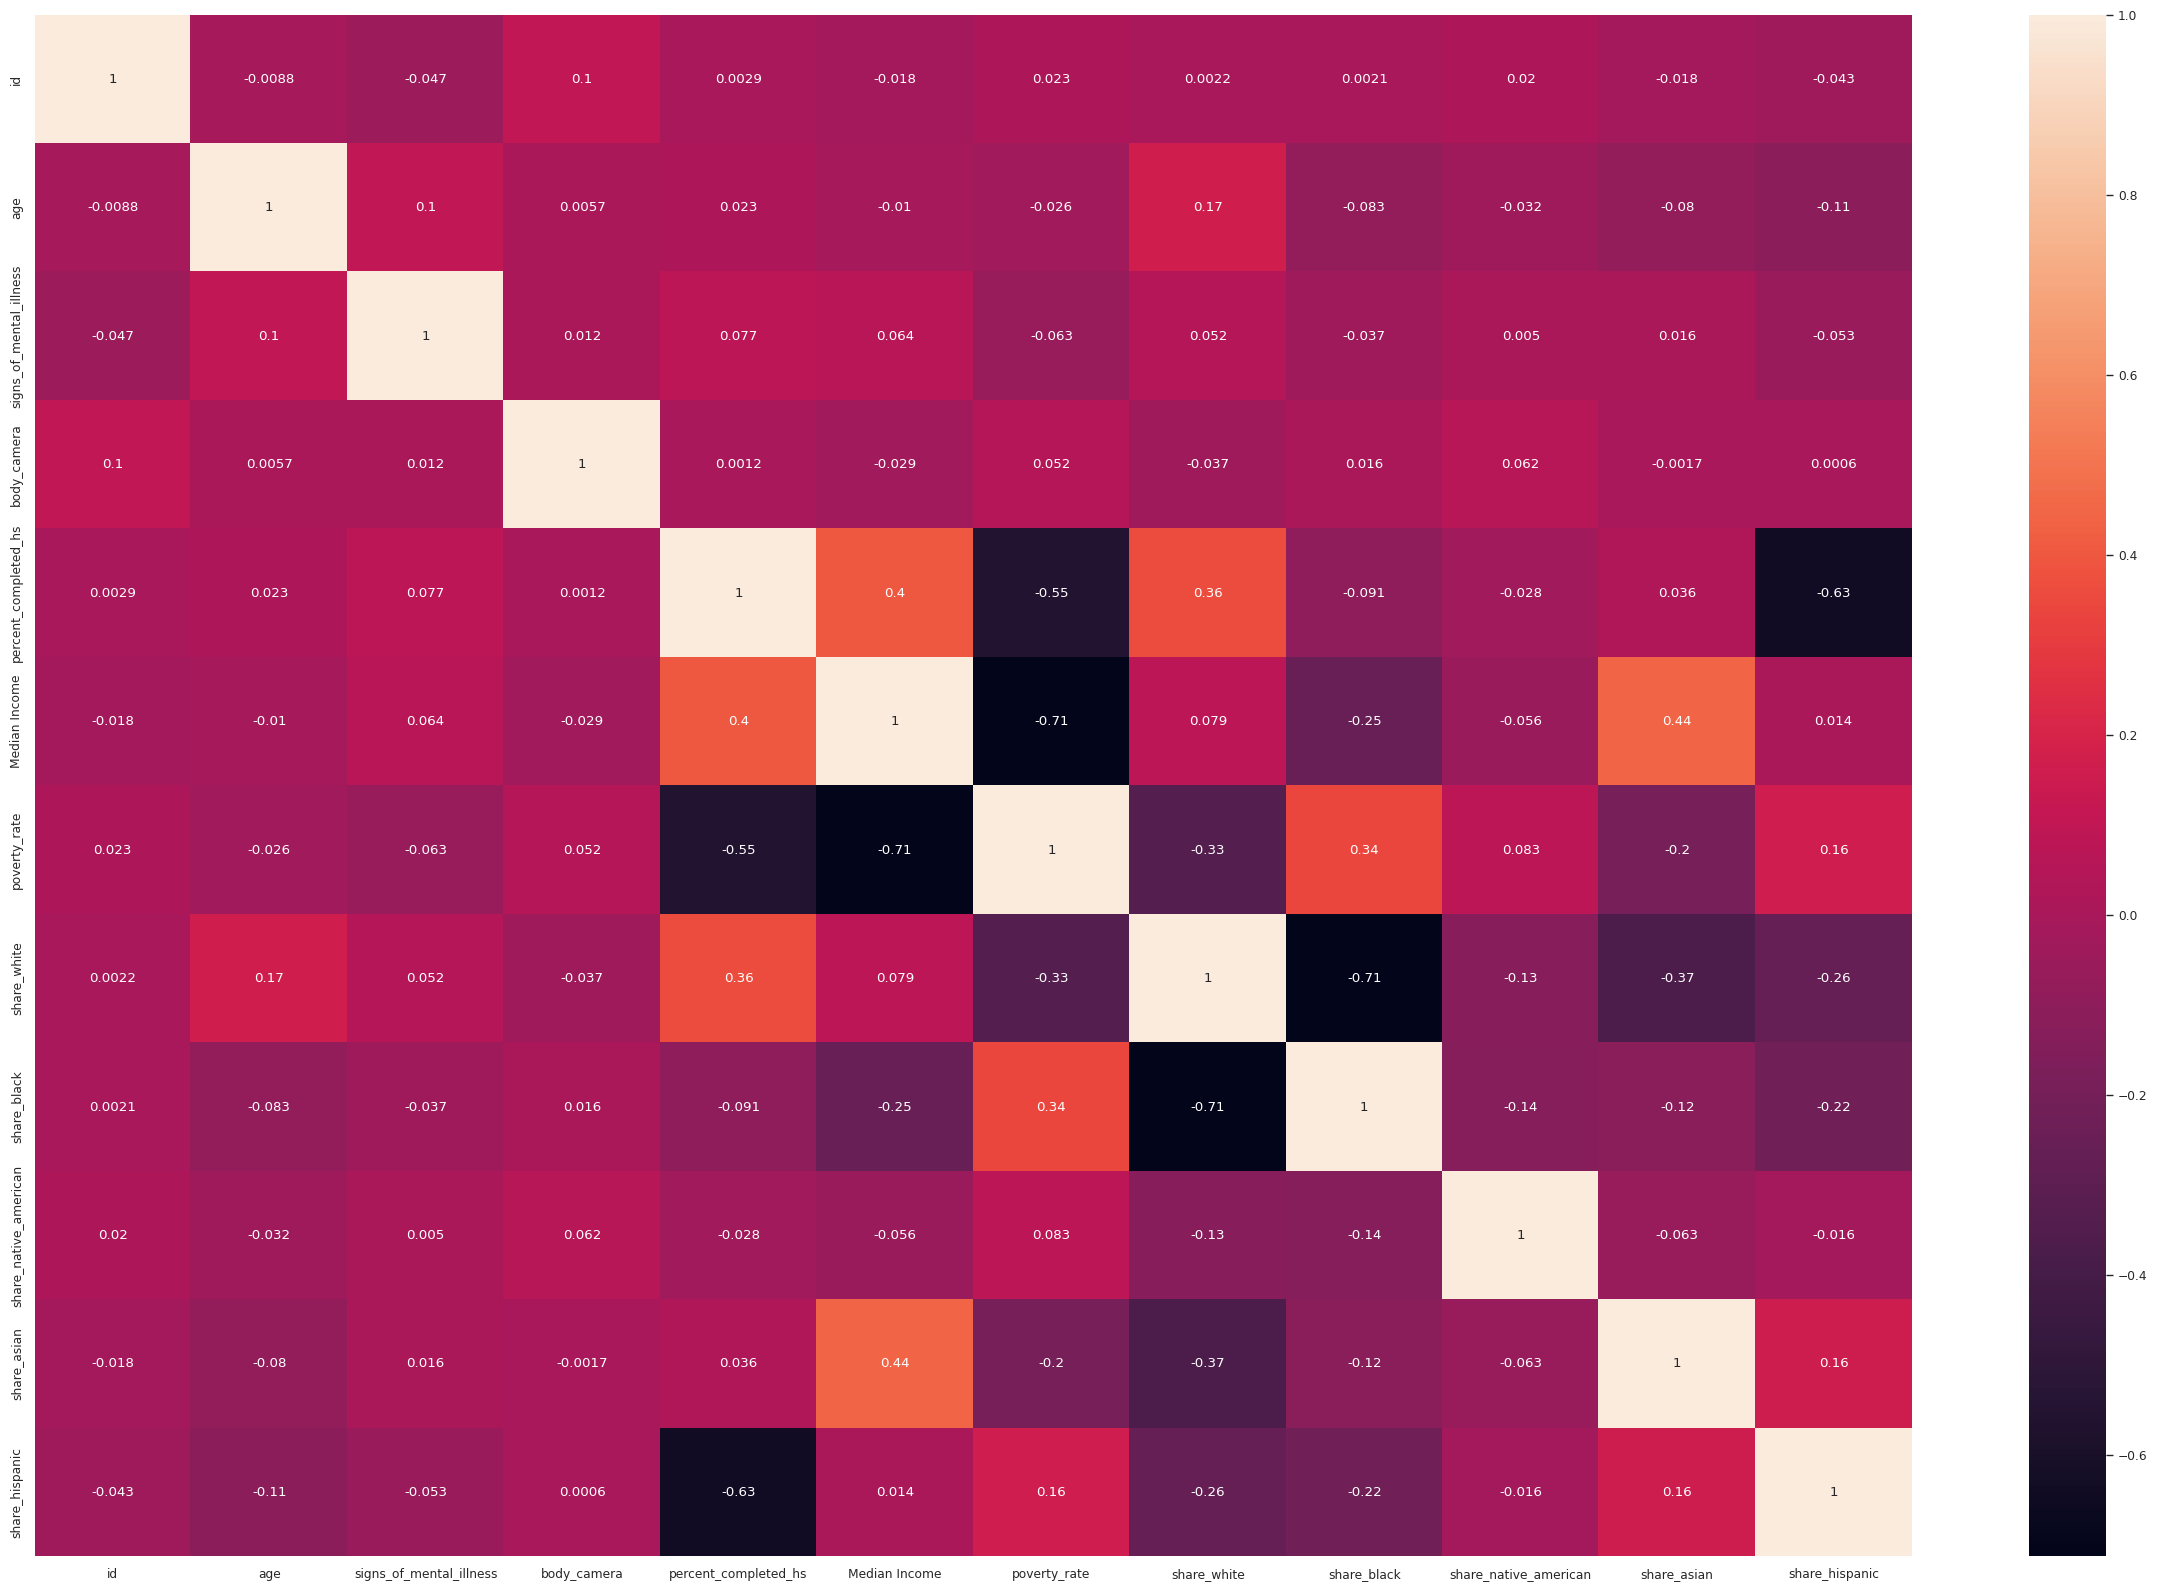

In [202]:
fig = plt.figure(dpi=100, figsize=(24, 16), tight_layout=True)
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

## Prediting Race of Victims

We now use a mixture of the features to predict the race of victims in fatal incidents.

### Logistic Regression

In [ ]:
clf = LogisticRegression(max_iter=10000, multi_class='multinomial')
clf.fit(X_train, y_train)
with open('output/logreg.pkl','wb') as f:
    pickle.dump(clf,f)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

Cross validation is implemented to reduce overfitting.

In [ ]:
clf = LogisticRegressionCV(max_iter=10000, multi_class='multinomial', cv=5)
clf.fit(X_train, y_train)
with open('output/logregCV.pkl','wb') as f:
    pickle.dump(clf,f)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

### Tree Classifier

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

plt.figure(figsize=(8, 6), dpi=100)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the incident features")
plt.show()
plt.savefig('incident_tree.png')

The large discrepancy between the accuracy of test and train data set respectively shows that the decision tree faces overfitting. We then turn to random forest to solve this problem by ensemble method.

In [ ]:
clf = RandomForestClassifier(max_depth=10, class_weight='balanced_subsample')
clf.fit(X_train, y_train)
with open('output/randomforest.pkl','wb') as f:
    pickle.dump(clf,f)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

## Predicting Count of Incidents

In this section, we would like to use the count of incidents by city as a dependent variable in regression to investigate what factors contribute to a high count.

In [ ]:
zero_count = city_total.loc[city_total['Counts'] == 0].shape[0]
print(f'There are {zero_count} cities with no fatal incident.')
print(f'They account for {zero_count/city_total.shape[0]*100}% of all the cities.')

We remove cities without accidents from the data set so that a relationship between cities and counts can be better formulated. Otherwise, a dummy regressor which contantly outputs 0 would achieve a good MSE.

In [ ]:
# drop city without accidents
city = city_total.loc[city_total['Counts'] != 0]
# drop city names and clean non-numerical data
city = city.drop(columns=['Geographic Area', 'City']).apply(pd.to_numeric, errors='coerce').dropna()
# scale columns
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(city.drop(columns='Counts')))
y = city['Counts']
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
X_train.head()

### Linear Regression

The low R2 score for linear regression suggests that a linear relationship cannot be established between city features and counts. However, on the scale of 1 to 35 (the highest count), the mean absolute error is acceptable.

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f'Train R2 = {reg.score(X_train, y_train)}.')
print(f'Test R2 = {reg.score(X_test, y_test)}.')
print(f'Test MAE = {mean_absolute_error(y_test, reg.predict(X_test))}.')
print(f'Test MSE = {mean_squared_error(y_test, reg.predict(X_test))}.')

### Neural Network

A neural network can model non-linear relationships between city features and counts.

In [ ]:
model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mse','mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print(f'Test MAE = {mean_absolute_error(y_test, y_pred)}.')
print(f'Test MSE = {mean_squared_error(y_test, y_pred)}.')

Contrary to our belief, the neural network ended up performing similarly to the linear regression. 